***Team Slytherin : Shayan Abbasi, Oscar Acuña Cornejo, Daniel Isita***

#**Importing Data**

In [ ]:
# Run this if running in Google Collab
# Mount google drive if running from Google Collab
from google.colab import drive
drive.mount('/content/drive')

# Set current directory if running from Google Collab

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DS/materials/linear_classification/Python')# here use your path to current notebook

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#First we import modules

import pandas as pd
%matplotlib inline
# This is a Python module that contains plotting commands
import matplotlib.pyplot as plt
# the following provides further tools for plotting with dfs
import seaborn as sns 
from sklearn.metrics import confusion_matrix
import numpy as np

#import auxiliar functions
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
from utils.helper_functions import *

In [ ]:
import pandas as pd
# Training dataset
train=pd.read_csv('../../Data/project/train_prob_death.csv') # this is a relative path from current folder to the folder where you have the dataset
test=pd.read_csv('../../Data/project/test_prob_death.csv')
train

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,ADMITTIME,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,1938-11-23,2008-06-15,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU
1,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,F,1929-04-30,2008-09-12,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU
2,0,86233,184606,237514,62.0,100.0,82.862069,62.0,154.0,114.642857,34.0,113.0,56.964286,48.0,122.0,72.750000,11.0,26.0,18.878788,36.111111,37.722222,36.907407,87.0,100.0,96.931034,116.0,183.0,142.166667,F,1935-05-15,2009-05-21,ELECTIVE,Medicare,PROTESTANT QUAKER,MARRIED,WHITE,LEFT LUNG CANCER/SDA,1625,SICU
3,0,53787,174772,244413,84.0,109.0,94.652174,81.0,163.0,121.727273,29.0,77.0,47.909091,49.0,87.0,65.727273,15.0,25.0,19.869565,35.611111,36.944444,36.203704,89.0,100.0,92.913043,233.0,484.0,361.000000,F,1937-01-14,2008-02-06,EMERGENCY,Medicare,CATHOLIC,DIVORCED,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
4,0,99384,168087,298919,74.0,98.0,81.142857,84.0,140.0,113.875000,35.0,72.0,54.343750,31.0,81.0,66.806452,17.0,28.0,23.264706,35.888889,37.111111,36.652778,88.0,99.0,94.600000,85.0,161.0,112.000000,M,1924-08-05,2010-02-24,EMERGENCY,Medicare,BUDDHIST,WIDOWED,WHITE,PULMONARY EMBOLISM,41511,TSICU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,0,9725,165189,261703,73.0,87.0,79.320000,95.0,129.0,109.200000,40.0,68.0,55.240000,24.0,81.0,66.480000,11.0,30.0,21.200000,36.222222,38.555556,37.138889,86.0,100.0,96.080000,61.0,136.0,108.333333,M,1940-02-16,2010-01-10,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,UROSEPSIS,5990,MICU
13836,0,22337,125014,296899,64.0,88.0,77.384615,87.0,142.0,114.500000,43.0,81.0,59.269231,58.0,96.0,72.846154,12.0,23.0,17.961538,35.888889,36.333333,36.055556,94.0,100.0,97.538462,86.0,108.0,98.000000,M,1921-06-23,2008-05-22,EMERGENCY,Medicare,OTHER,MARRIED,WHITE,GASTROINTESTINAL BLEED,56212,MICU
13837,0,5865,186505,232705,62.0,100.0,77.500000,62.0,154.0,104.792453,40.0,123.0,52.528302,47.0,109.0,66.018868,9.0,27.0,16.701754,35.000000,36.944444,35.777778,82.0,100.0,95.789474,93.0,120.0,109.750000,M,1920-04-21,2008-09-04,EMERGENCY,Medicare,JEWISH,MARRIED,WHITE,LOWER GASTROINTESTINAL BLEED,5789,MICU
13838,0,94290,148561,284582,73.0,115.0,93.200000,78.0,131.0,107.931034,21.0,73.0,56.068966,47.0,166.0,75.516129,5.0,27.0,15.548387,36.444444,36.888889,36.666667,83.0,100.0,98.400000,70.0,156.0,122.666667,F,1940-12-10,2009-05-01,EMERGENCY,Medicare,NOT SPECIFIED,MARRIED,WHITE,DYSPNEA;EKG CHANGE;ELEVATED TROP,41071,CSRU


#**Importing Extra data and the features it brings**

In [ ]:
extra =  pd.read_csv('../../Data/project/extra_diagnoses.csv')
extra.columns = ['subject_id', "hadm_id", 'SEQ_NUM', 'ICD9_diagnosis']

In [ ]:
sec_other_dignosis = extra.groupby(['subject_id', 'hadm_id'])[ 'SEQ_NUM'].count()
sec_other_dignosis

subject_id  hadm_id
2           163353      3
3           145834      9
4           185777      9
5           178980      3
6           107064      8
                       ..
99985       176670     13
99991       151118     17
99992       197084     12
99995       137810     17
99999       113369      5
Name: SEQ_NUM, Length: 58976, dtype: int64

In [ ]:
train = pd.merge(train, sec_other_dignosis, how='left', on=['subject_id', "hadm_id"])


In [ ]:
test = pd.merge(test, sec_other_dignosis, how='left', on=['subject_id', "hadm_id"])

In [ ]:
#test.SEQ_NUM.isna().value_counts()
#train.SEQ_NUM.isna().value_counts()

In [ ]:
#Creating Second Diaignosis
ICD = list(extra.groupby(['subject_id', "hadm_id"]).ICD9_diagnosis)
had = list(extra.groupby(['subject_id', "hadm_id"]).hadm_id)
sub = list(extra.groupby(['subject_id', "hadm_id"]).subject_id)
target = len(list(extra.groupby(['subject_id', "hadm_id"]).ICD9_diagnosis))
feature_list = ['subject_id', "hadm_id", 'ICD9_diagnosis_other']

In [ ]:
ls1 = [0]*target
ls2 = [0]*target
ls3 = [0]*target
for i in range(target):
  try:
    ls1[i] = list(ICD[i][1])[1]
  except:
    ls1[i] = 0
  ls2[i] = list(sub[i][1])[0]
  ls3[i] = list(had[i][1])[0]

In [ ]:
extra_df = pd.DataFrame(list(zip(ls2, ls3, ls1)))
extra_df.columns = feature_list
extra_df

,subject_id,hadm_id,ICD9_diagnosis_other
0,2,163353,V053
1,3,145834,78559
2,4,185777,1363
3,5,178980,V053
4,6,107064,4440
...,...,...,...
58971,99985,176670,51881
58972,99991,151118,0389
58973,99992,197084,56881
58974,99995,137810,42833


In [ ]:
train = pd.merge(train, extra_df, how='left', on=['subject_id', "hadm_id"])
test = pd.merge(test, extra_df, how='left', on=['subject_id', "hadm_id"])

In [ ]:
#just to check how many patients don't have second diagnosis which is 32
#train.ICD9_diagnosis_other.isna().value_counts()

Adding third diagnosis:

In [ ]:
ls1 = [0]*target
ls2 = [0]*target
ls3 = [0]*target
for i in range(target):
  try:
    ls1[i] = list(ICD[i][1])[2]
  except:
    ls1[i] = 0
  ls2[i] = list(sub[i][1])[0]
  ls3[i] = list(had[i][1])[0]
feature_list = ['subject_id', "hadm_id", 'ICD9_diagnosis_other2']

In [ ]:
extra_df2 = pd.DataFrame(list(zip(ls2, ls3, ls1)))
extra_df2.columns = feature_list
extra_df2

,subject_id,hadm_id,ICD9_diagnosis_other2
0,2,163353,V290
1,3,145834,5849
2,4,185777,7994
3,5,178980,V290
4,6,107064,9972
...,...,...,...
58971,99985,176670,48241
58972,99991,151118,5570
58973,99992,197084,5772
58974,99995,137810,99812


In [ ]:
train = pd.merge(train, extra_df2, how='left', on=['subject_id', "hadm_id"])
test = pd.merge(test, extra_df2, how='left', on=['subject_id', "hadm_id"])

In [ ]:
#just to check how many patients don't have second diagnosis which is 32
#train.ICD9_diagnosis_other.isna().value_counts()

# **Preprocessing and Feature Selection**

##**libraries and col names**

In [ ]:
import missingno
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
from math import *
import math
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from sklearn import base


In [ ]:
train.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'SEQ_NUM', 'ICD9_diagnosis_other',
       'ICD9_diagnosis_other2'],
      dtype='object')

In [ ]:
test.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'SEQ_NUM', 'ICD9_diagnosis_other',
       'ICD9_diagnosis_other2'],
      dtype='object')

In [ ]:
num_cols_names = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'SEQ_NUM']
cat_cols_names = ['GENDER', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS',
       'ICD9_diagnosis', 'FIRST_CAREUNIT', 'ICD9_diagnosis_other', 'ICD9_diagnosis_other2']
target_col = ['HOSPITAL_EXPIRE_FLAG']

## **Missing Data & Messy Data**


Here in Hospital data, we don't have missing data on categorical data except for marital. better to take care of numerical variables missing data by KNN. However, we first correct the outlier in Glucose_max.

(13840, 42)


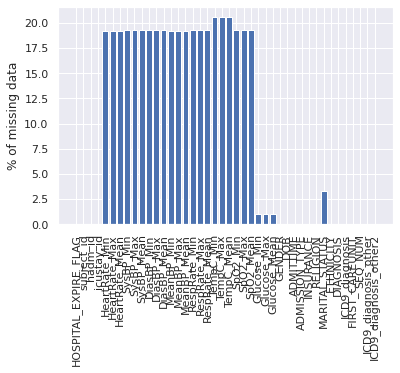

In [ ]:
# Missings report
train.replace([np.inf, -np.inf], np.nan)
Nulls_train = train.isnull().sum()
plt.xticks(rotation="vertical")
plt.bar(Nulls_train.index, 100*Nulls_train.values/len(train.index))
plt.ylabel("% of missing data")
print(train.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipyke

(12065, 41)


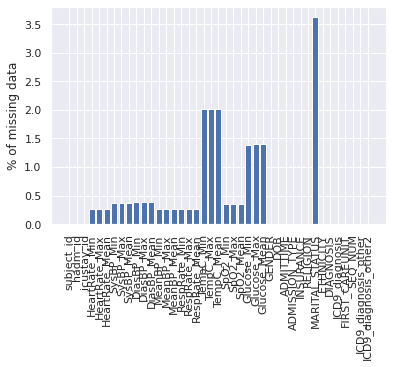

In [ ]:
# Missing report (data test)
test.replace([np.inf, -np.inf], np.nan)
# Glucose Max includes values as 999999
for i in range(len(test["Glucose_Max"])):
    if test.Glucose_Max[i]==999999:
        test.Glucose_Max[i] = np.nan
        test.Glucose_Mean[i] = np.nan
    else:
        if test.Glucose_Max[i]==9999:
            test.Glucose_Max[i] = np.nan
            test.Glucose_Mean[i] = np.nan
Nulls_test = test.isnull().sum()
plt.xticks(rotation="vertical")
plt.bar(Nulls_test.index, 100*Nulls_test.values/len(test.index))
plt.ylabel("% of missing data")
print(test.shape)

**KNN Imputing**

In [ ]:
imputer = KNNImputer(n_neighbors=50, weights="distance")
imputer = imputer.fit(pd.concat([train[num_cols_names], test[num_cols_names]]))
train[num_cols_names] = imputer.transform(train[num_cols_names])
test[num_cols_names] = imputer.transform(test[num_cols_names])

Now, we deal with marital_status missing data and messy values:
filling the unknown values with "UNKNOWN"



In [ ]:
train["MARITAL_STATUS"].value_counts()

MARRIED              6394
SINGLE               3893
WIDOWED              1916
DIVORCED              952
SEPARATED             151
UNKNOWN (DEFAULT)      70
LIFE PARTNER           10
Name: MARITAL_STATUS, dtype: int64

In [ ]:
test["MARITAL_STATUS"].value_counts()

MARRIED              5643
SINGLE               3391
WIDOWED              1593
DIVORCED              797
SEPARATED             139
UNKNOWN (DEFAULT)      60
LIFE PARTNER            5
Name: MARITAL_STATUS, dtype: int64

In [ ]:
#Marital status
train["MARITAL_STATUS"][train["MARITAL_STATUS"].isna()] = "UNKNOWN"
train["MARITAL_STATUS"][train["MARITAL_STATUS"] == "UNKNOWN (DEFAULT)"] = "UNKNOWN"
train["MARITAL_STATUS"].value_counts()
#train["MARITAL_STATUS"].isna().value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


MARRIED         6394
SINGLE          3893
WIDOWED         1916
DIVORCED         952
UNKNOWN          524
SEPARATED        151
LIFE PARTNER      10
Name: MARITAL_STATUS, dtype: int64

In [ ]:
test["MARITAL_STATUS"][test["MARITAL_STATUS"].isna()] = "UNKNOWN"
test["MARITAL_STATUS"][test["MARITAL_STATUS"] == "UNKNOWN (DEFAULT)"] = "UNKNOWN"
test["MARITAL_STATUS"].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


MARRIED         5643
SINGLE          3391
WIDOWED         1593
DIVORCED         797
UNKNOWN          497
SEPARATED        139
LIFE PARTNER       5
Name: MARITAL_STATUS, dtype: int64

Since we are going to use target encoding for categorical variable, we don't neet to handle messy data.

## **Feature engineering**

1. calculating Age out of Admited time and DOB.
2. Dealing with similar concepts of marital status.
3. No minority regroup needed since we use target encoding.
4. Check for abnormal variables like Age>120.

one time do step 2,3 and see the result. One time don't do 2,3.

### calculating age and drippings and abnormal age

In [ ]:
# 9. Previous stay in ICU
def perv_stay(data):
  num_prev_stay_list_tuple = []
  for i in data.groupby('subject_id'):
    temp_df = i[1]
    if temp_df.shape[0]>1:
        temp_df = temp_df.sort_values(by='ADMITTIME')['icustay_id']
        for k in range(0,temp_df.shape[0]):
            num_prev_stay_list_tuple.append((i[0],temp_df.iloc[k],k))
            
    else:
        num_prev_stay_list_tuple.append((i[0],i[1]['icustay_id'].iloc[0],0))
        
  num_prev_table = pd.DataFrame(num_prev_stay_list_tuple,\
                                columns=['subject_id', 'icustay_id', 'num_prev_stay'])
  data = data.merge(num_prev_table, left_on=['subject_id','icustay_id'],\
                          right_on=['subject_id','icustay_id'],\
                          how = 'left')
  return data

In [ ]:
train = perv_stay(train)

In [ ]:
test = perv_stay(test)

In [ ]:
def Age_cal(data):
  data["Age"] = [float(data['ADMITTIME'][i][0:4]) - float(data["DOB"][i][0:4]) for i in range(len(data.DOB))]
  data = data.drop(['DOB',"ADMITTIME"], axis=1)
  return data

In [ ]:
train = Age_cal(train)

In [ ]:
# 8. Remove abnormal age
train = train[train.Age<122]

In [ ]:
test = Age_cal(test)

In [ ]:
num_cols_names = num_cols_names + ["Age", 'num_prev_stay']

### Categorical Feature engineering

In [ ]:
create_cat_features = True

In [ ]:
if create_cat_features == True: 
  def cat_features(train):
    #SPO2:
    train['Spo2_situation'] = pd.Series(["normal" if i>=95 else "considerable" if \
                                        (i<95 and i>85) else "critical" if i<85 \
                                        else None for i in train.SpO2_Mean])
    #TempC:
    train["TempC_situation"] = pd.Series(['critical' if (i>41 and i <44) else \
                                          'deadly' if i>=44 else "fever" if \
                                          (i>37.8 and i<41) else 'hypothermy' if \
                                          i<36.1 else 'normal' for i in train.TempC_Mean])
    #pulse_pressure:
    train['Pulse_presure'] = pd.Series(['normal' if (i>=40 and i<=60) else \
                                        'heart failure' if i<40 else 'Hypertension' \
                                        if i>60 else 'unknown' for i in \
                                        train.SysBP_Mean-train.DiasBP_Mean])
    #age & Heart Rate:
    train['Heart_Rate_situation'] = pd.Series(["normal" if (j<1 and i>=90 and i<=170)\
                                              else "bad" if (j<1 and (i>170 or i<90)) \
                                              else 'normal' if \
                                              (j>=1 and j<3 and i>=80 and i<=150)\
                                              else 'bad' if (j>=1 and j<3 and (i<80 or i>150)) \
                                              else 'normal' if (j>=3 and j<6 and (i>=70 and i<=120))\
                                              else 'bad' if (j>=3 and j<6 and(i>120 or i <70))\
                                              else 'normal' if(j>=6 and j<12 and (i>=60 and i <=110))\
                                              else 'bad' if (j>=6 and j<12 and (i<60 or i >110)) \
                                              else 'normal' if (j>=12 and (i>=60 and i<=100)) \
                                              else 'bad' if (j>=12 and (i<60 or i>100)) \
                                              else 'unknown' for i,j in \
                                              zip(train.HeartRate_Mean, train.Age)])
    #Respiratory situation:
    train['Resp_rate_situation'] = pd.Series(["normal" if (j<1 and i>=22 and i<=70)\
                                              else "bad" if (j<1 and (i>70 or i<22)) \
                                              else 'normal' if \
                                              (j>=1 and j<3 and i>=22 and i<=30)\
                                              else 'bad' if (j>=1 and j<3 and (i<22 or i>30)) \
                                              else 'normal' if (j>=3 and j<6 and (i>=20 and i<=24))\
                                              else 'bad' if (j>=3 and j<6 and(i>24 or i <20))\
                                              else 'normal' if(j>=6 and j<12 and (i>=16 and i <=22))\
                                              else 'bad' if (j>=6 and j<12 and (i<16 or i >22)) \
                                              else 'normal' if (j>=12 and (i>=12 and i<=20)) \
                                              else 'bad' if (j>=12 and (i<12 or i>20)) \
                                              else 'unknown' for i,j in \
                                              zip(train.RespRate_Mean, train.Age)])
    #Diabetes:
    train['Diabetes_situation'] = pd.Series(['normal' if i<140 else 'Prediabetes' \
                                            if i>=140 and i<200 else 'Diabetes' \
                                            if i>= 200 else 'unknown' \
                                            for i in train.Glucose_Mean])
    
    print(train['Resp_rate_situation'].value_counts())
    print(train['Heart_Rate_situation'].value_counts())
    print(train['Pulse_presure'].value_counts())
    print(train["TempC_situation"].value_counts())
    print(train['Spo2_situation'].value_counts())
    print(train['Diabetes_situation'].value_counts())
    return train
  train = cat_features(train)
  test = cat_features(test)
  cat_cols_names = cat_cols_names + ['Spo2_situation',
       'TempC_situation', 'Pulse_presure', 'Heart_Rate_situation',
       'Resp_rate_situation', 'Diabetes_situation']
  num_cols_names = num_cols_names 

normal    9619
bad       4221
Name: Resp_rate_situation, dtype: int64
normal    11540
bad        2300
Name: Heart_Rate_situation, dtype: int64
normal           8105
Hypertension     4621
heart failure    1114
Name: Pulse_presure, dtype: int64
normal        11959
hypothermy     1419
fever           462
Name: TempC_situation, dtype: int64
normal          10564
considerable     3222
critical           53
Name: Spo2_situation, dtype: int64
normal         8795
Prediabetes    3810
Diabetes       1235
Name: Diabetes_situation, dtype: int64
normal    7937
bad       4128
Name: Resp_rate_situation, dtype: int64
normal    9577
bad       2488
Name: Heart_Rate_situation, dtype: int64
normal           6602
Hypertension     4318
heart failure    1145
Name: Pulse_presure, dtype: int64
normal        10322
hypothermy     1224
fever           519
Name: TempC_situation, dtype: int64
normal          10368
considerable     1661
critical           36
Name: Spo2_situation, dtype: int64
normal         7582
Pre

###Differencing Features

In [ ]:
Create_Differencing_Features = True

In [ ]:
if Create_Differencing_Features == True:
  def diff_Features(data):
    data['heartRate_fluc'] = data['HeartRate_Max'] - data['HeartRate_Min']
    data['SysBP_fluc'] = data['SysBP_Max'] - data['SysBP_Min']
    data['DiasBP_fluc'] = data['DiasBP_Max'] - data['DiasBP_Min']
    data['BP_fluc'] = data['SysBP_Mean'] - data['DiasBP_Mean']
    data['MeanBP_fluc'] = data['MeanBP_Max'] - data['MeanBP_Min']
    data['renal_resistive_index'] = data['DiasBP_Mean'] / data['SysBP_Mean']
    data['RespRate_fluc'] = data['RespRate_Max'] - data['RespRate_Min']
    data['TempC_fluc'] = data['TempC_Max'] - data['TempC_Min']
    data['SpO2_fluc'] = data['SpO2_Max'] - data['SpO2_Min']
    data['Glucose_fluc'] = data['Glucose_Max'] - data['Glucose_Min']
    return data
  train = diff_Features(train)
  test = diff_Features(test)
  num_cols_names = num_cols_names + ['heartRate_fluc' , 'SysBP_fluc', 'DiasBP_fluc',\
                                     'BP_fluc' , 'MeanBP_fluc', 'renal_resistive_index',\
                                     'RespRate_fluc', 'TempC_fluc', 'SpO2_fluc',\
                                     'Glucose_fluc']

## **Target encoding**

In [ ]:
test.shape

(12065, 57)

In [ ]:
pip install category_encoders

In [ ]:
from category_encoders import TargetEncoder
encoder = TargetEncoder()
train[cat_cols_names] = encoder.fit_transform(train[cat_cols_names], train[target_col])

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
test[cat_cols_names] = encoder.transform(test[cat_cols_names])

In [ ]:
test.shape

(12065, 57)

## **EDA: Outliers**

Quantile method and 3*sd method, both show outliers. I guess this may lead to overfitting, so maybe we should use log(data) from now on. I don't suggest to remove outlier since I think they have valuable information.

In [ ]:
#Change to true if you want the exploratory data.
Should_plot = True

In [ ]:
#Plotting for outliers
def outlier_plotter(data, col_names):
  for name in col_names:
    plt.hist(data[name])
    plt.title(name)
    col_mean = data[name].mean(skipna=True)
    col_sd = sqrt(data[name].var())
    #Q1 = data[name].quantile(0.25)
    #Q3 = data[name].quantile(0.75)
    plt.axvline(col_mean+col_sd*3, color="red")
    plt.axvline(col_mean-col_sd*3, color="red")
    plt.show()

In [ ]:
# Let’s plot the distribution of each feature
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
        plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


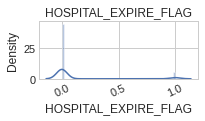

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


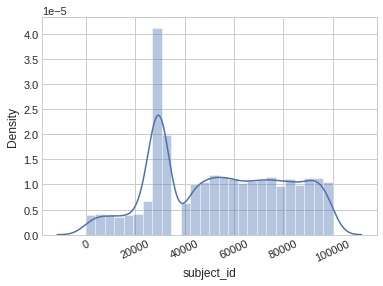

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


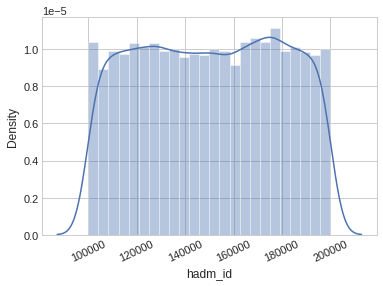

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


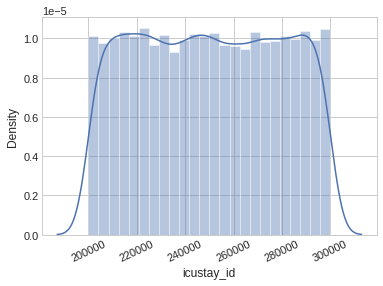

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


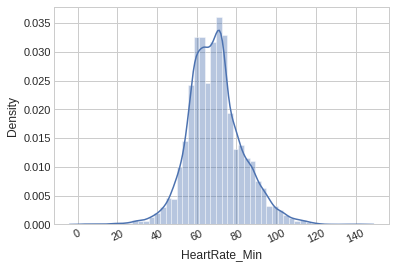

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


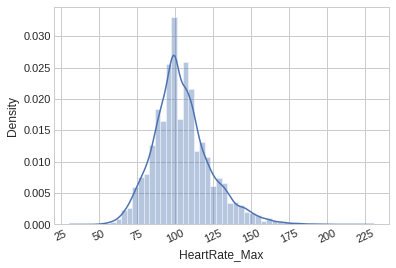

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


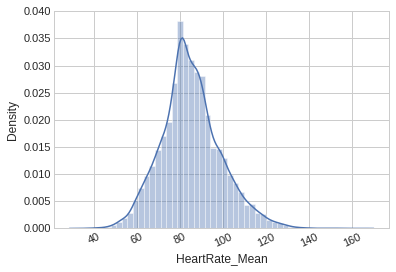

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


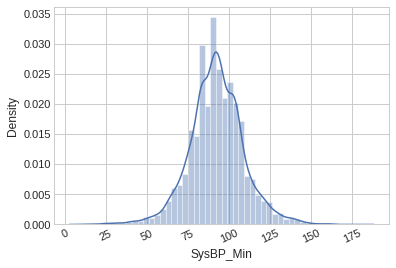

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


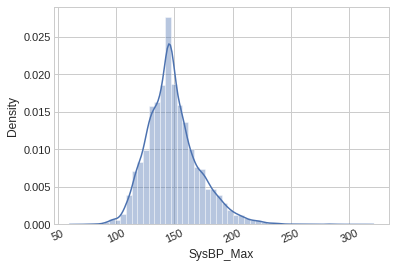

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


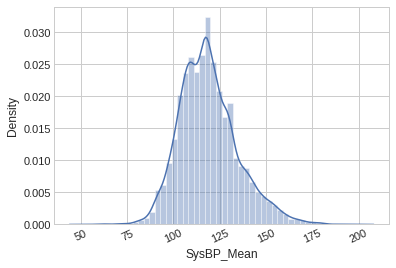

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


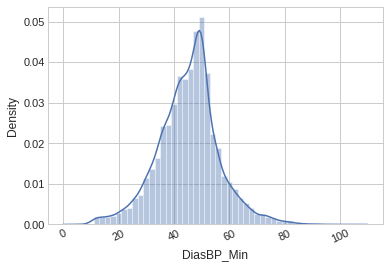

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


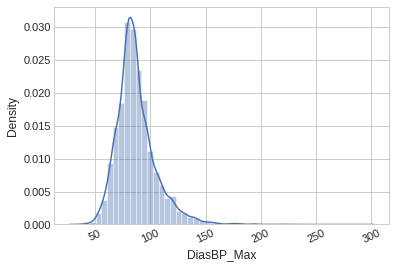

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


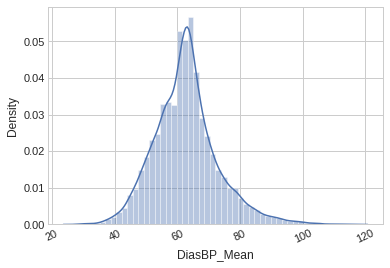

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


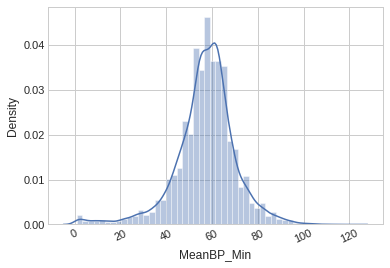

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


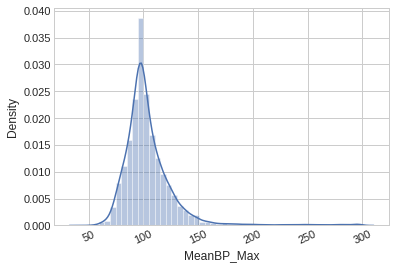

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


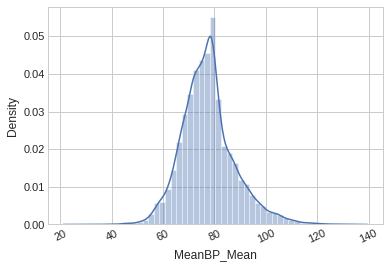

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


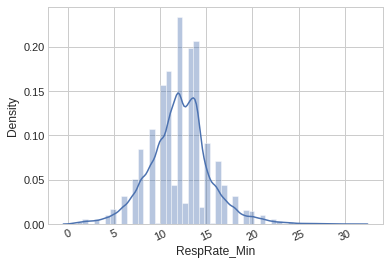

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


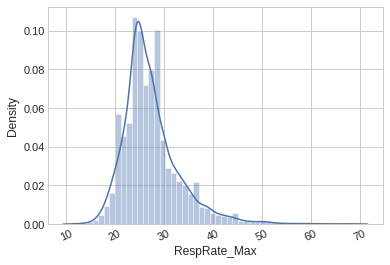

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


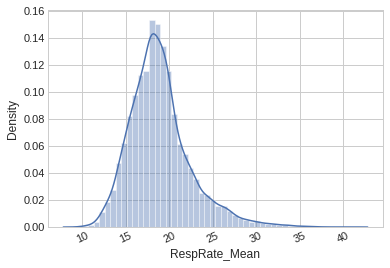

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


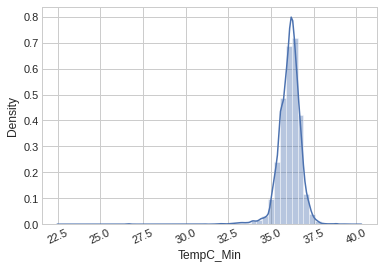

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


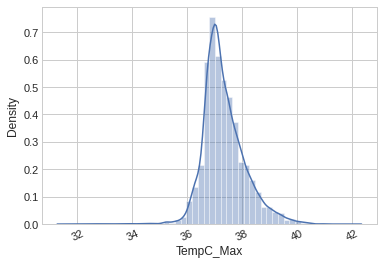

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


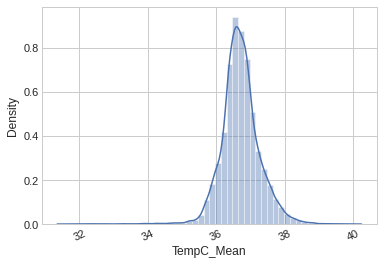

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


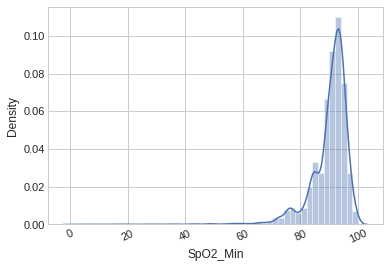

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


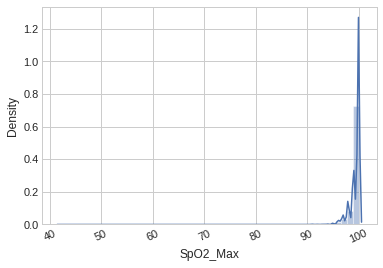

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


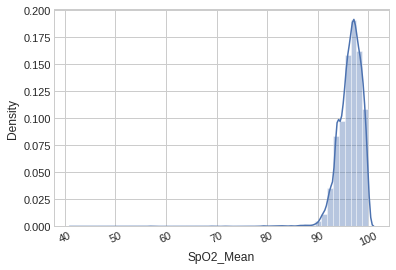

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


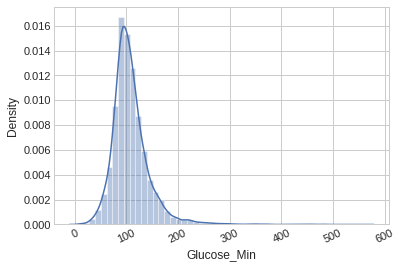

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


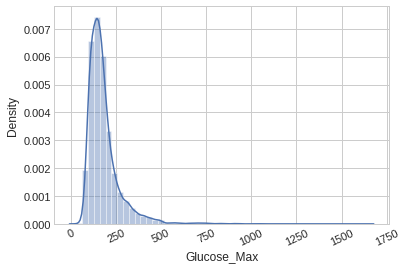

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


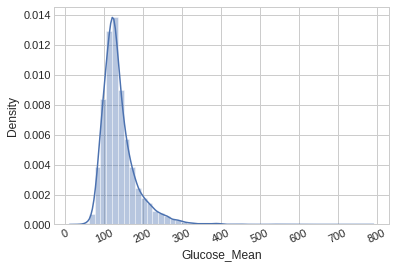

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


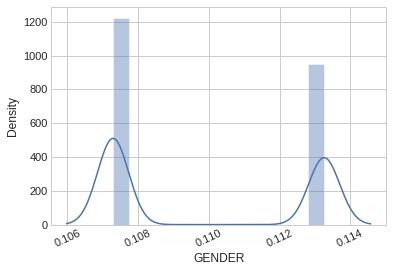

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


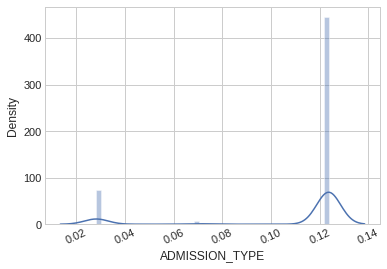

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


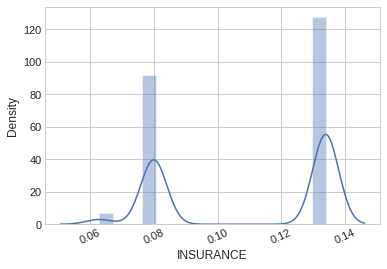

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


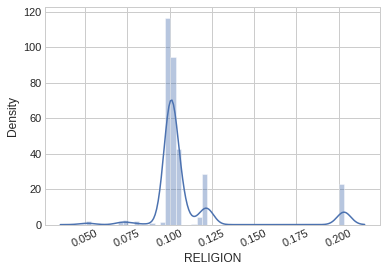

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


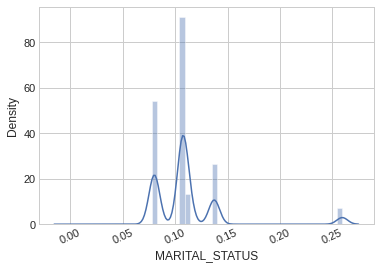

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


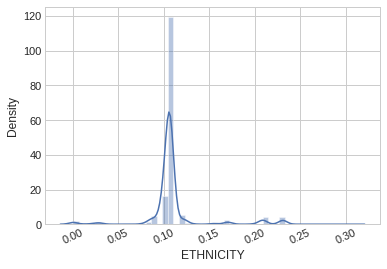

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


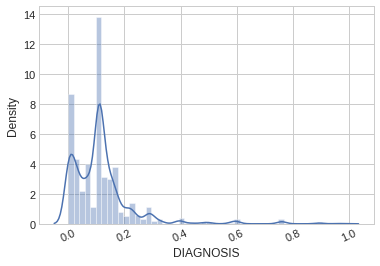

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


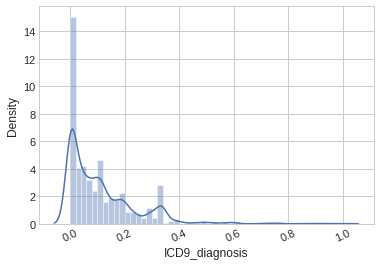

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


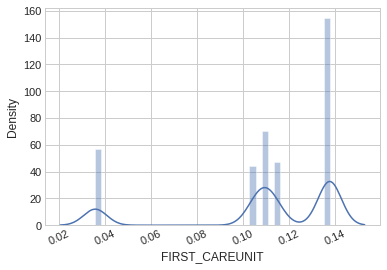

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


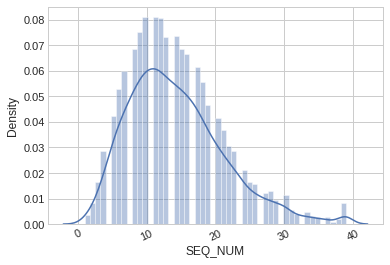

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


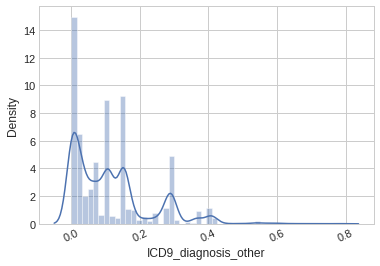

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


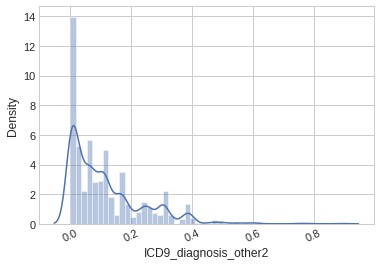

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


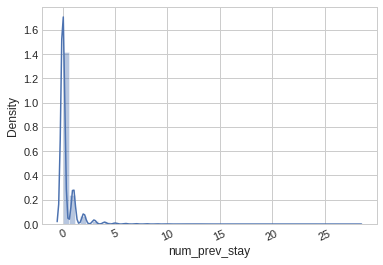

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


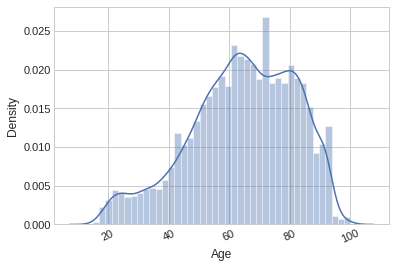

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


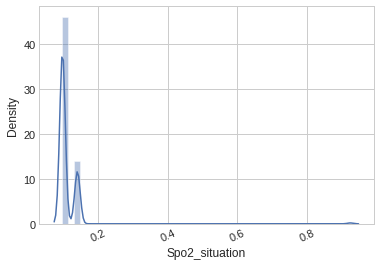

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


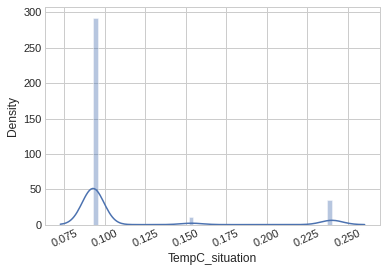

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


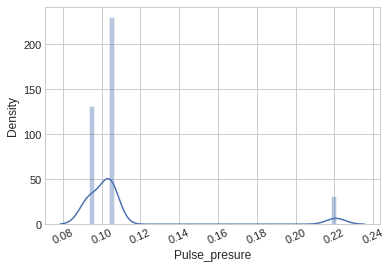

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


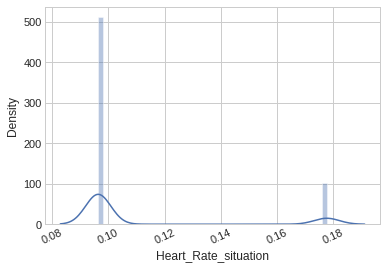

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


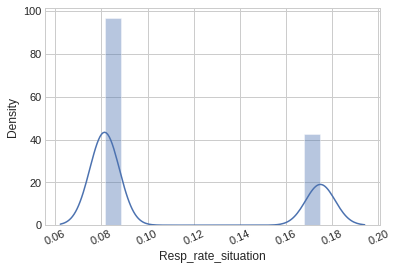

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


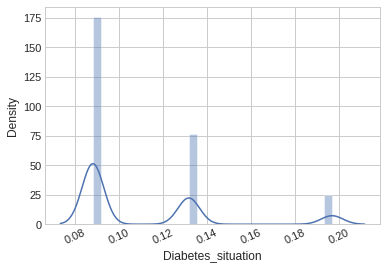

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


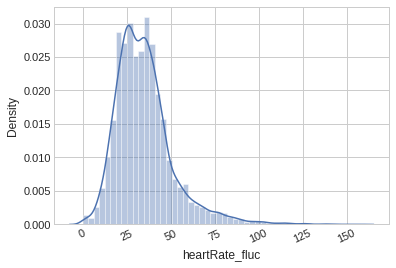

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


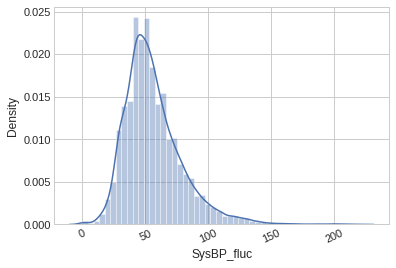

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


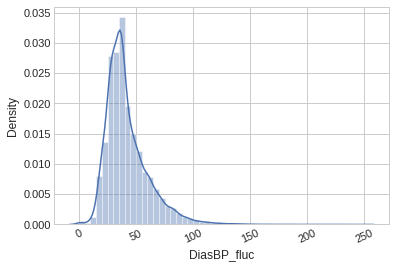

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


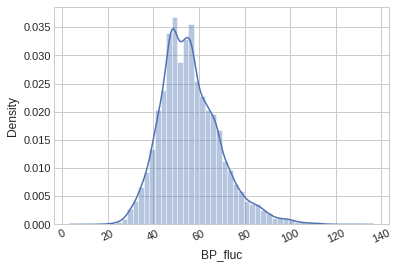

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


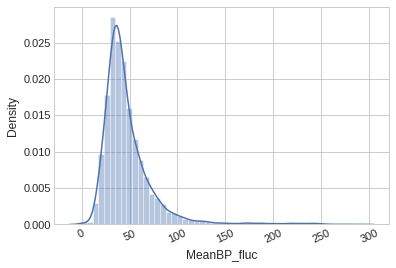

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


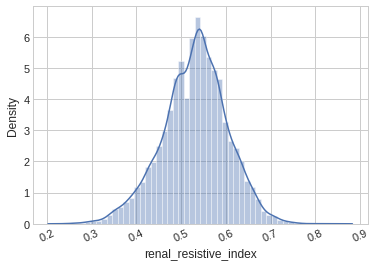

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


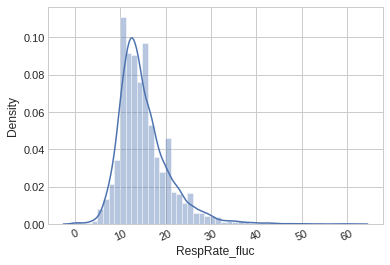

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


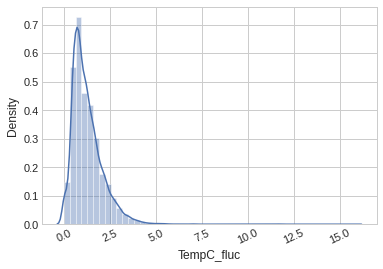

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


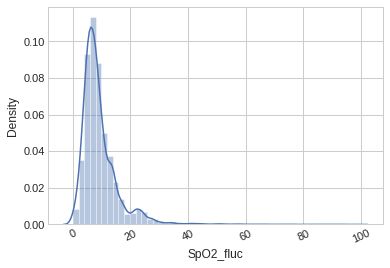

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


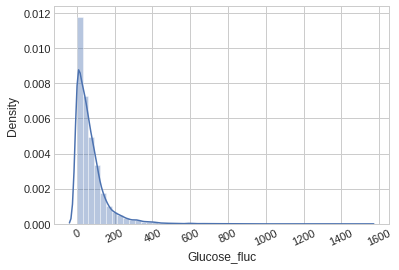

In [ ]:
if Should_plot == True:
  plot_distribution(train)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


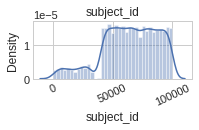

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


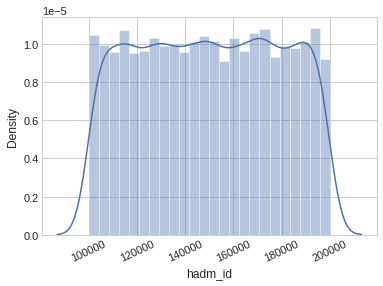

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


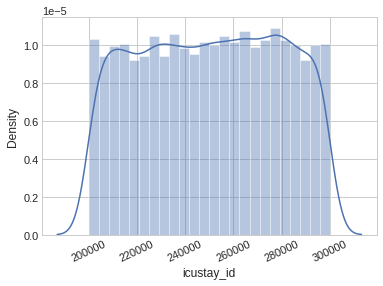

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


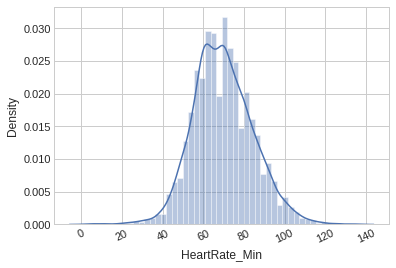

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


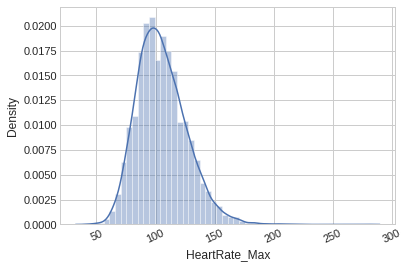

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


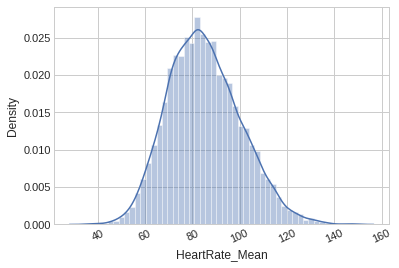

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


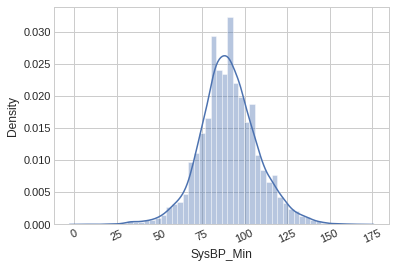

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


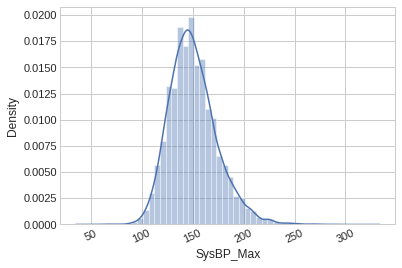

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


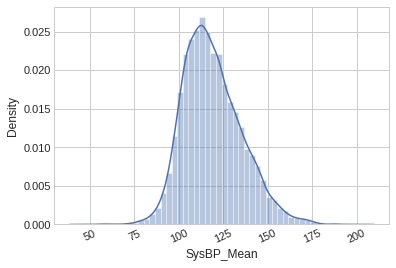

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


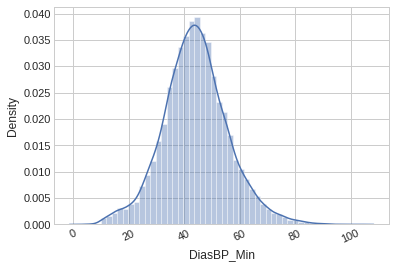

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


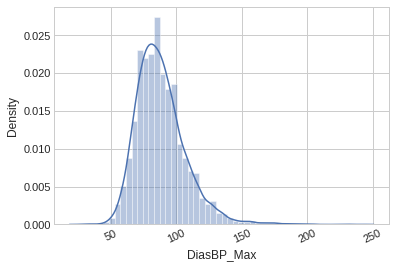

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


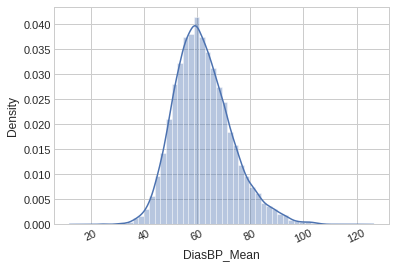

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


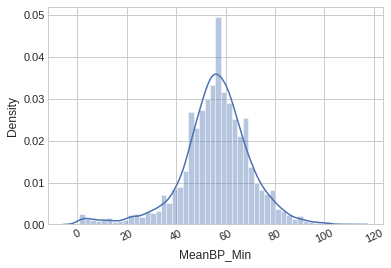

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


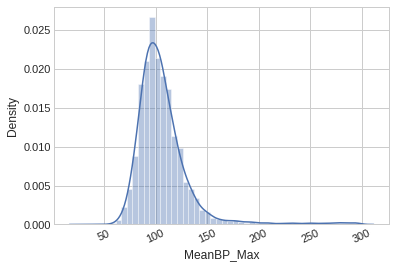

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


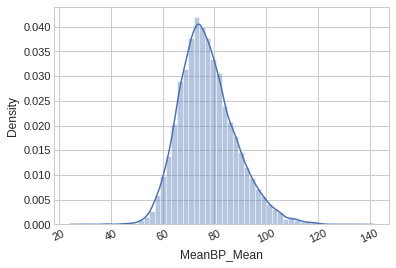

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


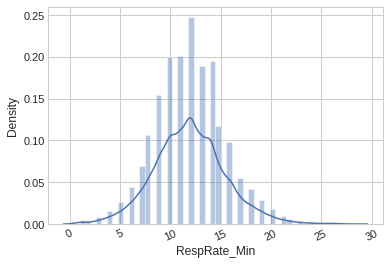

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


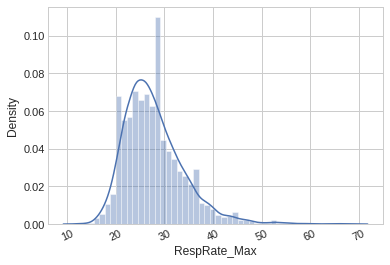

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


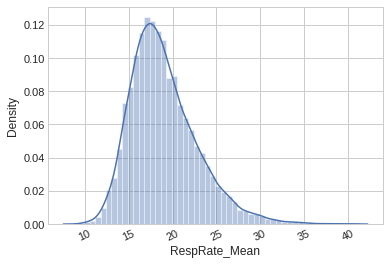

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


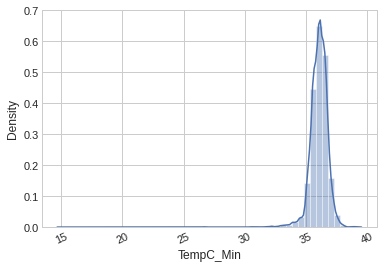

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


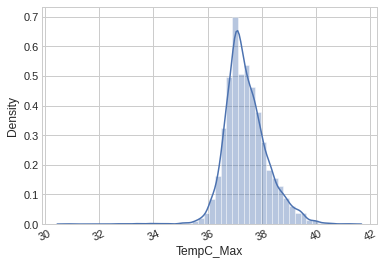

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


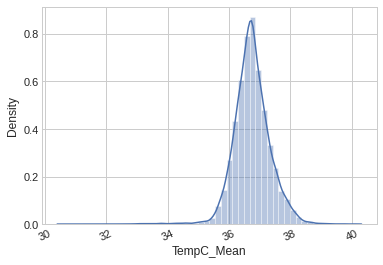

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


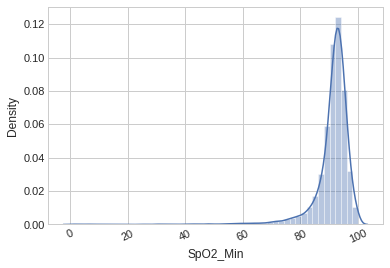

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


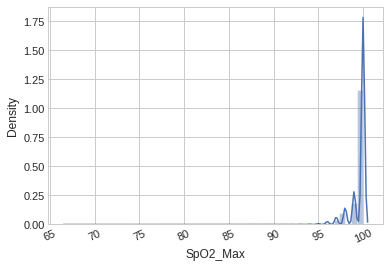

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


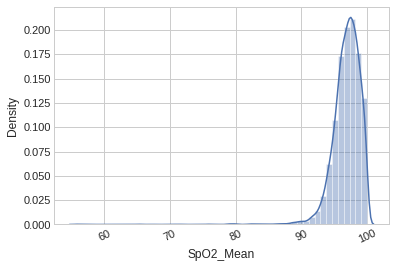

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


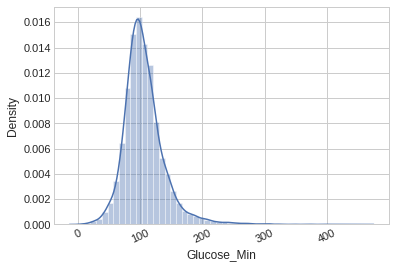

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


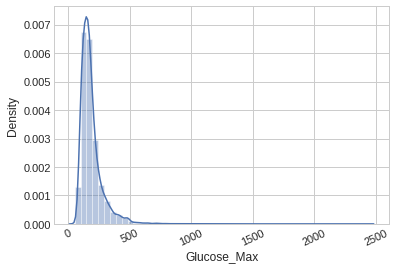

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


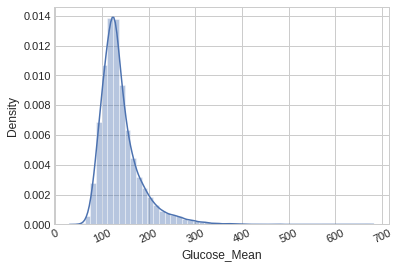

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


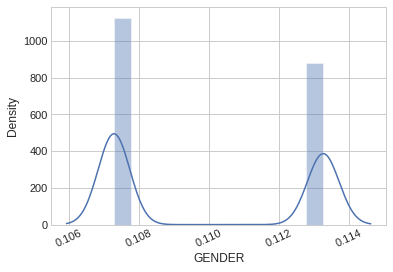

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


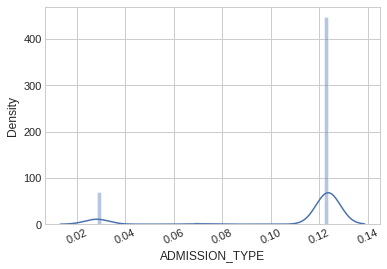

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


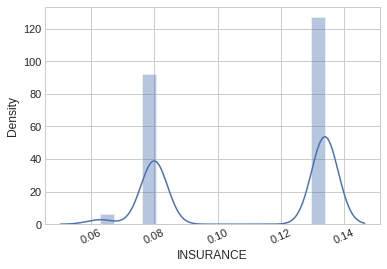

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


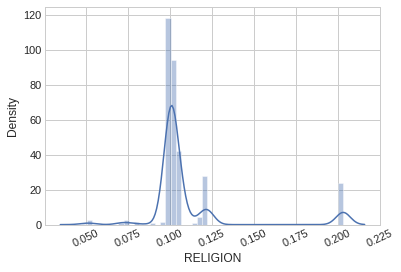

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


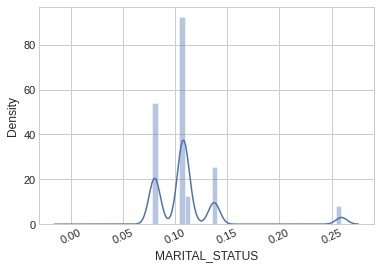

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


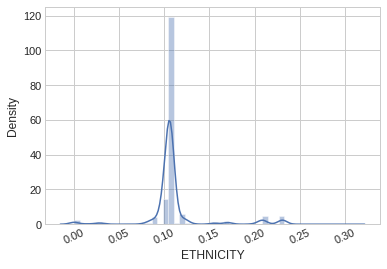

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


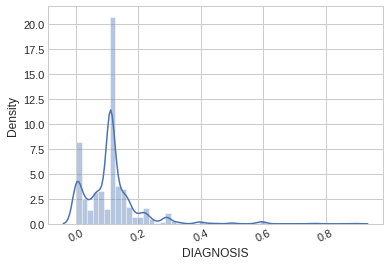

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


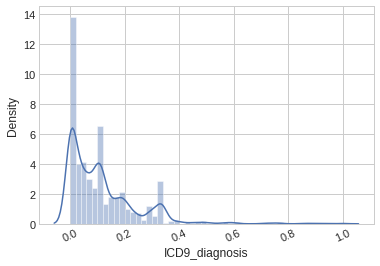

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


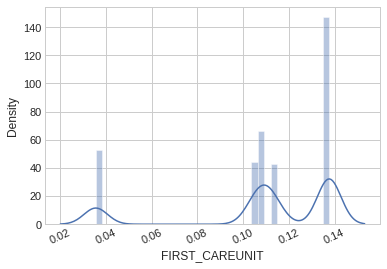

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


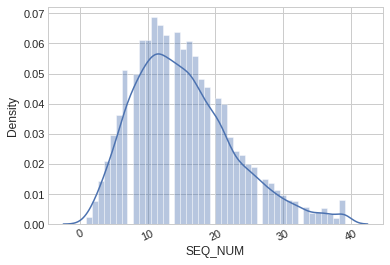

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


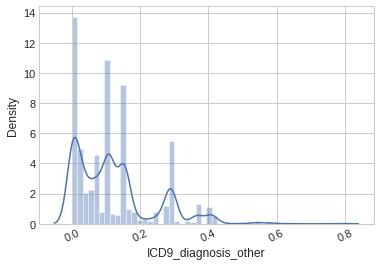

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


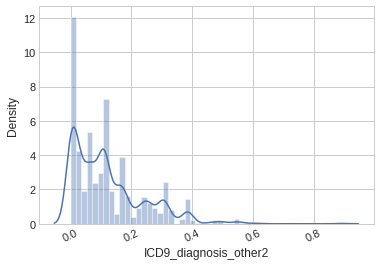

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


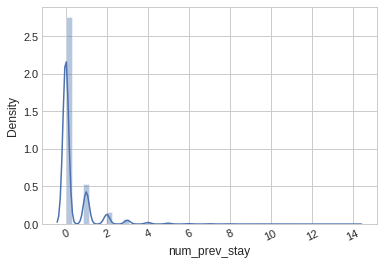

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


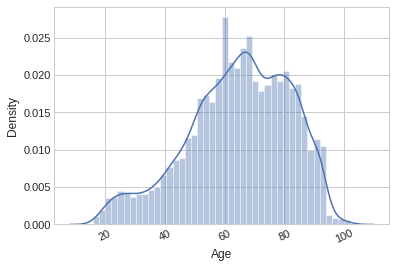

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


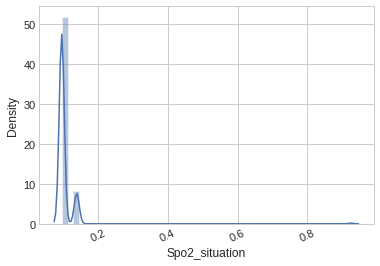

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


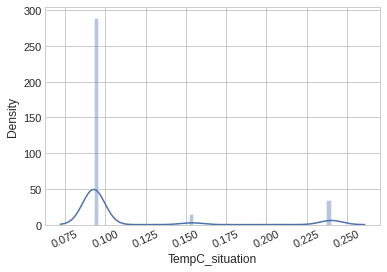

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


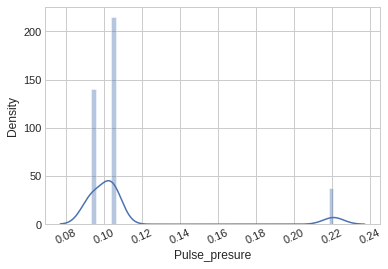

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


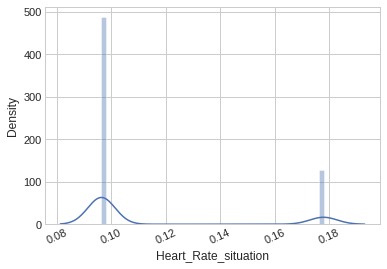

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


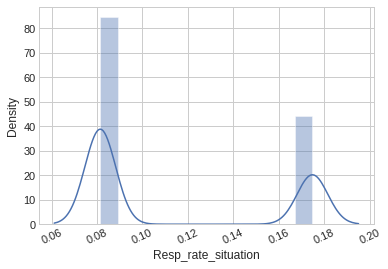

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


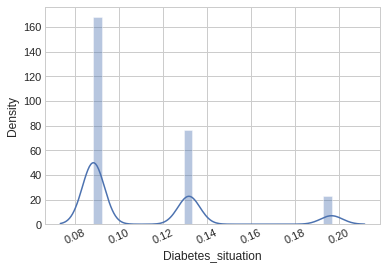

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


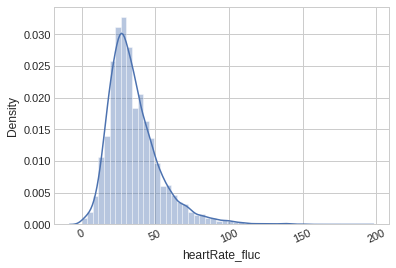

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


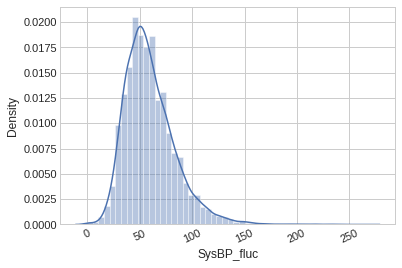

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


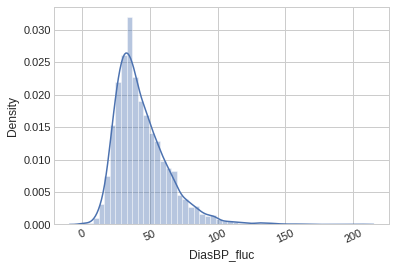

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


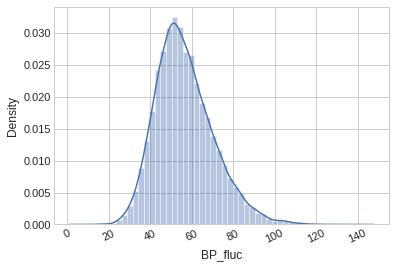

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


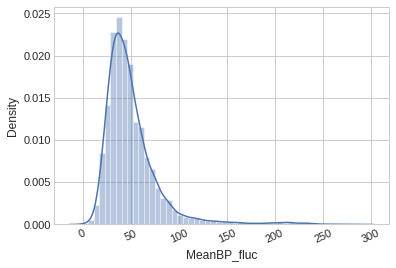

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


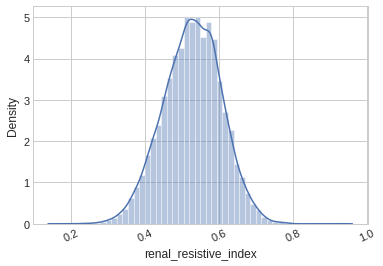

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


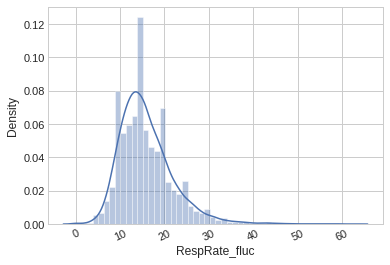

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


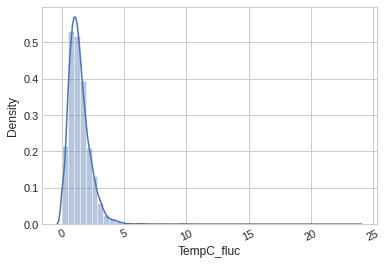

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


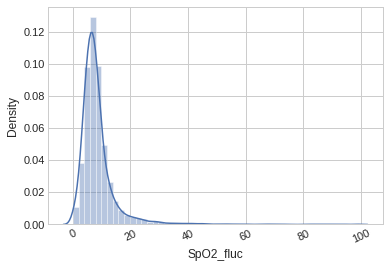

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


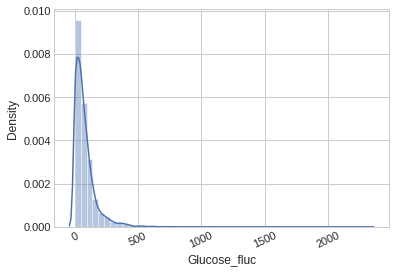

In [ ]:
if Should_plot == True:
  plot_distribution(test)

Fishy columns even after log transformation:

outlier on left:

HeartRate_mean, SysBP_Min, DiasBP_Min, MeanBP_Min, MeanBP_Mean, RespRate_Min(weird), TempC_min, SpO2_Min, SpO2_Max, SpO2_Mean, Glucose_Min

Fat tail:
MeanBP_Max(right)

Other info:
1.  Has anyone stayed in the hospital before? id_check. (since the id seems to have high modes, maybe for seniors or people with critical conditions)
2. if in the training data there was a dead person, in the test data he/she should not be dead then.





**Note: glucose has outliers 9999, fix it.**

In [ ]:
def corr_plot(data):
  # Sample figsize in inches
  fig, ax = plt.subplots(figsize=(20,10))         
  # Imbalanced DataFrame Correlation
  corr = data.corr()
  sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
  ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
  plt.show()

Here we see colinearity in some groups of X's.

In [ ]:
#corr_plot(train)

In [ ]:
#corr_plot(test)

# **Scaling**

1. Why scaling?
2. What method is suitable?

In [ ]:
train.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'SEQ_NUM', 'ICD9_diagnosis_other',
       'ICD9_diagnosis_other2', 'num_prev_stay', 'Age', 'Spo2_situation',
       'TempC_situation', 'Pulse_presure', 'Heart_Rate_situation',
       'Resp_rate_situation', 'Diabetes_situation', 'heartRate_fluc',
       'SysBP_fluc', 'DiasBP_fluc', 'BP_fluc', 'MeanBP_fluc',
       'renal_resistive_index', 'RespRate_fluc', 'TempC_fluc', 'SpO2_fluc',
       

In [ ]:
new_col_names = num_cols_names + cat_cols_names

In [ ]:
scaling = "maxmin"

In [ ]:
if scaling=='maxmin':
  # data normalization with sklearn
  from sklearn.preprocessing import MinMaxScaler

  # fit scaler on training data
  norm = MinMaxScaler().fit(train[new_col_names])

  # transform training data
  X = norm.transform(train[new_col_names])

  # transform testing dataabs
  X_test = norm.transform(test[new_col_names])

In [ ]:
if scaling =='standard':
  from sklearn.preprocessing import StandardScaler
  # define standard scaler
  scaler = StandardScaler()
  # transform data
  X = scaler.fit_transform(train[new_col_names])
  X_test = scaler.fit_transform(test[new_col_names])

# **Imbalance**


1. Do we have imbalance? Yes
2. Do we need to deal with imbalance?
either with resampling, or smote (oversampling) with imbalancelearn from sklearn

In [ ]:
Imbalance = 'smote'

## Undersampling

In [ ]:
if Imbalance == "undersample":
  train["HOSPITAL_EXPIRE_FLAG"].value_counts().plot(kind="bar")
  def target_encoder(data, target, n_balance=1):
    freq = data[target].sum()/len(data[target])
    sample_size = min(data[target].value_counts())
    data['freq'] = data.groupby(target)[target].transform("count")
    data = data.sample(n_balance*sample_size, weights = (1/data.freq), replace =\
                      False, random_state=1)
    data = data.drop(['freq'], axis=1)
    data[target].value_counts().plot(kind="bar")
    return data
  train = target_encoder(train, "HOSPITAL_EXPIRE_FLAG")
  X = train[new_col_names]
  y = train.HOSPITAL_EXPIRE_FLAG

## SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 12319, 1: 12319})


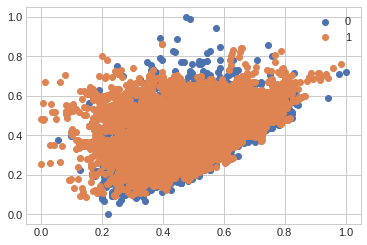

In [ ]:
if Imbalance == "smote":
  import imblearn
  # Oversample and plot imbalanced dataset with SMOTE
  from collections import Counter
  from sklearn.datasets import make_classification
  from imblearn.over_sampling import SMOTE
  from matplotlib import pyplot
  from numpy import where
  def smote_resampling(data, target):
    oversample = SMOTE()
    X, y = oversample.fit_resample(data, target)
    # summarize the new class distribution
    counter = Counter(y)
    print(counter)
    # scatter plot of examples by class label
    for label, _ in counter.items():
      row_ix = where(y == label)[0]
      pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    pyplot.legend()
    pyplot.show()
    return X,y
  
  X,y = smote_resampling(X, train[target_col[0]])

Remmember: test data won't need any imbalance adjustment. balancing data is just for train.

In [ ]:
if Imbalance == None:
  y = train[target_col[0]]
  X = train[new_col_names]
  X.columns = new_col_names

# **Models**

1. Which model we should use?
2. What are hyper parameters?
3. how to optimize hyperparameters?
4. how to split data to train and test within training data?

Notice: When we evaluate models with all the data, we are looking for a possible overfitting. The real performance is with the splitted test data.

In [ ]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  cross_val_score
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
class_labels = ["survived", "expired"]
# Split dataset into training set and test set
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
ID_test = test.icustay_id

## *Logestic Regression*

### Split $\to$ Gridsearch $\to$ Train $\to$ Test

In [ ]:
from sklearn.model_selection import StratifiedKFold
#Grid Search with cross-validation for Binary model
logreg_init = LogisticRegression( max_iter=30000)

#Notice: params were tuned with different values, however for the sake of speed 
#we changed them to optimum values here.
grid_values = {'solver':['saga'], 'dual':[False], \
               'penalty':['l2'],'intercept_scaling':[1], \
               "C":[1.0],'multi_class':['auto'], 'tol':[0.0001], \
              'class_weight': [None], 'fit_intercept':[True],\
              'random_state':[None], 'verbose':[0], 'warm_start':[False]}

grid_logreg = GridSearchCV(logreg_init, param_grid = grid_values,scoring = 'precision',
                                cv=StratifiedKFold(n_splits=10, shuffle=True),
                                refit=True,n_jobs=10)


grid_logreg.fit(X_train_DT, y_train_DT)
grid_logreg.best_params_

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'multi_class': 'auto',
 'penalty': 'l2',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Accuracy: 0.8781114718614719


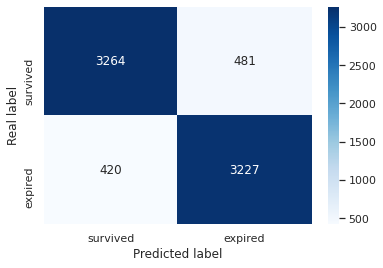

In [ ]:
y_pred_test = grid_logreg.predict(X_test_DT)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_DT, y_pred_test))
cm =  confusion_matrix(y_pred=y_pred_test, y_true=y_test_DT, labels=[0,1])
plot_confusion_matrix(cm, class_labels)

In [ ]:
from sklearn.metrics import accuracy_score
print ("Accuracy (cross-validated): ", round(accuracy_score(y_test_DT, y_pred_test),3))

####  Classification report
from sklearn.metrics import classification_report
print (classification_report(y_test_DT, y_pred_test))

Accuracy (cross-validated):  0.878
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3745
           1       0.87      0.88      0.88      3647

    accuracy                           0.88      7392
   macro avg       0.88      0.88      0.88      7392
weighted avg       0.88      0.88      0.88      7392



### All Data $\to$ Train $\to$ Test $\to$ export result

In [ ]:
from sklearn.model_selection import StratifiedKFold
#Grid Search with cross-validation for Binary model
logreg_init = LogisticRegression( max_iter=300000)

#Notice: params were tuned with different values, however for the sake of speed 
#we changed them to optimum values here.
grid_values = {'solver':['lbfgs'], 'dual':[False], \
               'penalty':['l2'],'intercept_scaling':[1], \
               "C":[1.0],'multi_class':['auto'], 'tol':[0.0001], \
              'class_weight': [None], 'fit_intercept':[True],\
              'random_state':[None], 'verbose':[0], 'warm_start':[False]}

grid_logreg = GridSearchCV(logreg_init, param_grid = grid_values,scoring = 'precision',
                                cv=StratifiedKFold(n_splits=10, shuffle=True),
                                refit=True,n_jobs=10)


grid_logreg.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=300000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=10,
             param_grid={'C': [1.0], 'class_weight': [None], 'dual': [False],
                         'fit_intercept': [True], 'intercept_scaling': [1],
                         'multi_class': ['auto'], 'penalty': ['l2'],
                         'random_state': [None], 'solve

Accuracy: 0.8808750710284926


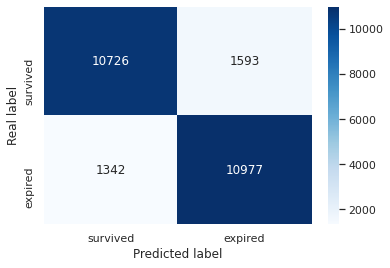

In [ ]:
y_pred = grid_logreg.predict(X)
# Model Accuracy, how often is the classifier? correct
print("Accuracy:",metrics.accuracy_score(y, y_pred))
cm =  confusion_matrix(y_pred=y_pred, y_true=y, labels=[0,1])
plot_confusion_matrix(cm, class_labels)

In [ ]:
from sklearn.metrics import accuracy_score
print ("Accuracy (cross-validated): ", round(accuracy_score(y, y_pred),3))

####  Classification report
from sklearn.metrics import classification_report
print (classification_report(y, y_pred))

Accuracy (cross-validated):  0.881
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     12319
           1       0.87      0.89      0.88     12319

    accuracy                           0.88     24638
   macro avg       0.88      0.88      0.88     24638
weighted avg       0.88      0.88      0.88     24638



In [ ]:
y_pred_prob_test = grid_logreg.predict_proba(X_test)

In [ ]:
result = pd.DataFrame(ID_test)
result['HOSPITAL_EXPIRE_FLAG'] = y_pred_prob_test[:,1]
result.to_csv('../../Data/project/LR_test_result_new19.csv', index=False)

In [ ]:
result

,icustay_id,HOSPITAL_EXPIRE_FLAG
0,221004,0.022698
1,296315,0.632284
2,245557,0.039990
3,287519,0.019604
4,231164,0.070809
...,...,...
12060,209815,0.585550
12061,233792,0.932772
12062,225430,0.003206
12063,222434,0.023865


In [ ]:
train

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,SEQ_NUM,ICD9_diagnosis_other,num_prev_stay,Age,Spo2_situation,TempC_situation,Pulse_presure,Heart_Rate_situation,Resp_rate_situation,Diabetes_situation,heartRate_fluc,SysBP_fluc,DiasBP_fluc,BP_fluc,MeanBP_fluc,renal_resistive_index,RespRate_fluc,TempC_fluc,SpO2_fluc,Glucose_fluc
0,0,55440,195768,228357,89.000000,145.000000,121.043478,74.000000,127.000000,106.586957,42.0,90.000000,61.173913,59.0,94.0,74.543478,15.000000,30.000000,22.347826,35.111111,36.944444,36.080247,90.000000,99.000000,95.739130,111.0,230.0,160.777778,0.113261,0.123736,0.133845,0.105978,0.080144,0.105966,0.066116,7.031250e-02,0.137661,17.0,0.292121,0,70.0,0.096649,0.240310,0.104010,0.177826,0.174840,0.131759,56.000000,53.000000,48.000000,45.413043,35.0,0.573934,15.000000,1.833333,9.000000,119.0
1,0,28424,127337,225281,71.333333,88.666667,82.204959,101.833333,128.166667,114.790843,49.5,82.333333,66.315876,61.0,91.0,77.651515,11.166667,23.833333,16.808686,36.533333,37.122222,36.784722,89.333333,97.666667,94.159635,97.0,137.0,113.000000,0.113261,0.123736,0.133845,0.122050,0.137265,0.105966,0.142857,2.796520e-14,0.113779,16.0,0.147368,1,79.0,0.139665,0.092734,0.104010,0.096360,0.081401,0.088232,17.333333,26.333333,32.833333,48.474967,30.0,0.577711,12.666667,0.588889,8.333333,40.0
2,0,86233,184606,237514,62.000000,100.000000,82.862069,62.000000,154.000000,114.642857,34.0,113.000000,56.964286,48.0,122.0,72.750000,11.000000,26.000000,18.878788,36.111111,37.722222,36.907407,87.000000,100.000000,96.931034,116.0,183.0,142.166667,0.113261,0.028184,0.133845,0.105978,0.107288,0.105966,0.013100,4.166667e-02,0.109189,18.0,0.147368,0,74.0,0.096649,0.092734,0.104010,0.096360,0.081401,0.131759,38.000000,92.000000,79.000000,57.678571,74.0,0.496885,15.000000,1.611111,13.000000,67.0
3,0,53787,174772,244413,84.000000,109.000000,94.652174,81.000000,163.000000,121.727273,29.0,77.000000,47.909091,49.0,87.0,65.727273,15.000000,25.000000,19.869565,35.611111,36.944444,36.203704,89.000000,100.000000,92.913043,233.0,484.0,361.000000,0.113261,0.123736,0.133845,0.100516,0.113445,0.105966,0.038462,1.027343e-14,0.137661,12.0,0.106557,0,71.0,0.139665,0.092734,0.093486,0.096360,0.081401,0.196761,25.000000,82.000000,48.000000,73.818182,38.0,0.393577,10.000000,1.333333,11.000000,251.0
4,0,99384,168087,298919,74.000000,98.000000,81.142857,84.000000,140.000000,113.875000,35.0,72.000000,54.343750,31.0,81.0,66.806452,17.000000,28.000000,23.264706,35.888889,37.111111,36.652778,88.000000,99.000000,94.600000,85.0,161.0,112.000000,0.107290,0.123736,0.133845,0.078947,0.137265,0.105966,0.037037,7.355366e-04,0.113779,18.0,0.000000,1,86.0,0.139665,0.092734,0.104010,0.096360,0.174840,0.088232,24.000000,56.000000,37.000000,59.531250,50.0,0.477223,11.000000,1.222222,11.000000,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,0,9725,165189,261703,73.000000,87.000000,79.320000,95.000000,129.000000,109.200000,40.0,68.000000,55.240000,24.0,81.0,66.480000,11.000000,30.000000,21.200000,36.222222,38.555556,37.138889,86.000000,100.000000,96.080000,61.0,136.0,108.333333,0.107290,0.123736,0.133845,0.100516,0.107288,0.105966,0.066667,3.921569e-02,0.137661,8.0,0.106557,0,70.0,0.096649,0.092734,0.104010,0.096360,0.174840,0.088232,14.000000,34.000000,28.000000,53.960000,57.0,0.505861,19.000000,2.333333,14.000000,75.0
13836,0,22337,125014,296899,64.000000,88.000000,77.384615,87.000000,142.000000,114.500000,4

## *Decision Tree*

### Split $\to$ Gridsearch $\to$ Train $\to$ Test

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#Notice: params were tuned with different values, however for the sake of speed 
#we changed them to optimum values here.
params = {'ccp_alpha':[0.0], 'class_weight':[None],
          'criterion':['gini'], 'max_depth':[9],
          'max_features':[None],
          'max_leaf_nodes':[None],
          'min_impurity_decrease':[0.0],
          'min_impurity_split':[None],
          'min_samples_leaf':[1],
          'min_samples_split':[2],
          'min_weight_fraction_leaf':[0.0],
          'presort':['deprecated'],
          'random_state':[42],
          'splitter':['best']
          }
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42),\
                              params, verbose=1, cv=10,  scoring="precision")
grid_search_cv.fit(X_train_DT, y_train_DT)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.3s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='dep...
                         'criterion': ['gini'], 'max_depth': [9],
                         'max_fe

Accuracy: 0.9093614718614719


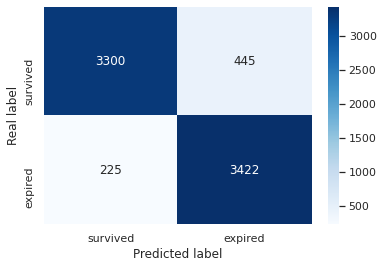

In [ ]:
y_pred_test = grid_search_cv.predict(X_test_DT)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_DT, y_pred_test))
cm =  confusion_matrix(y_pred=y_pred_test, y_true=y_test_DT, labels=[0,1])
plot_confusion_matrix(cm, class_labels)

AUC:  0.9511815589600685


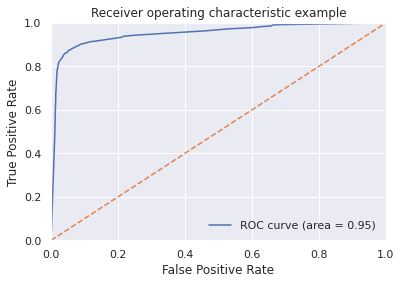

In [ ]:
#this part should be for test data, but I just wanted to see it
y_prob_DT = grid_search_cv.predict_proba(X_test_DT)
get_auc(np.array(y_test_DT), y_prob_DT, class_labels, column=0, plot=True)

In [ ]:
from sklearn.metrics import accuracy_score
print ("Accuracy (cross-validated): ", round(accuracy_score(y_test_DT, y_pred_test),3))

####  Classification report
from sklearn.metrics import classification_report
print (classification_report(y_test_DT, y_pred_test))

Accuracy (cross-validated):  0.909
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      3745
           1       0.88      0.94      0.91      3647

    accuracy                           0.91      7392
   macro avg       0.91      0.91      0.91      7392
weighted avg       0.91      0.91      0.91      7392



### All Data $\to$ Train $\to$ Test $\to$ export result

In [ ]:
grid_search_cv.fit(X, y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.8s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='dep...
                         'criterion': ['gini'], 'max_depth': [9],
                         'max_fe

Accuracy: 0.934775549963471


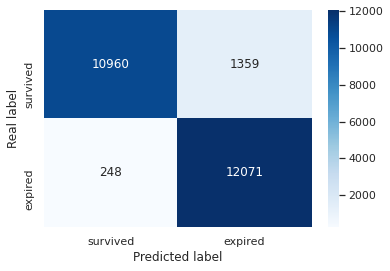

In [ ]:
y_pred = grid_search_cv.predict(X)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y, y_pred))
cm =  confusion_matrix(y_pred=y_pred, y_true=y, labels=[0,1])
plot_confusion_matrix(cm, class_labels)

In [ ]:
from sklearn.metrics import accuracy_score
print ("Accuracy (cross-validated): ", round(accuracy_score(y, y_pred),3))

####  Classification report
from sklearn.metrics import classification_report
print (classification_report(y, y_pred))

Accuracy (cross-validated):  0.935
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     12319
           1       0.90      0.98      0.94     12319

    accuracy                           0.93     24638
   macro avg       0.94      0.93      0.93     24638
weighted avg       0.94      0.93      0.93     24638



In [ ]:
y_pred_prob_test = grid_search_cv.predict_proba(X_test)

In [ ]:
result = pd.DataFrame(ID_test)
result['HOSPITAL_EXPIRE_FLAG'] = y_pred_prob_test[:,1].round(2)
result.to_csv('../../Data/project/DT_test_result_new13.csv', index=False)

When we have out of sample data, sometimes, Decision Tree models won't be as accurate as they should be.

## Random forest

### Split $\to$ Gridsearch $\to$ Train $\to$ Test

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

np.random.seed(31415) # impose random seed for reproducibility

# to print stats
feature_names = train[new_col_names].columns
class_labels = ["POS", "POD"]


forest = RandomForestClassifier(n_estimators=9)
scores = cross_val_score(forest, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


importances = forest.fit(X, y).feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)




Accuracy: 0.95 (+/- 0.06)


ICD9_diagnosis           1.000000
ICD9_diagnosis_other     0.885522
DIAGNOSIS                0.855483
ICD9_diagnosis_other2    0.719622
MARITAL_STATUS           0.268666
num_prev_stay            0.228062
Age                      0.114639
FIRST_CAREUNIT           0.103989
Spo2_situation           0.098137
SpO2_Min                 0.097369
RespRate_Max             0.086195
RELIGION                 0.084422
RespRate_Mean            0.075743
SEQ_NUM                  0.074924
SysBP_Min                0.068024
SpO2_fluc                0.067339
Glucose_Max              0.067137
Glucose_fluc             0.066189
Pulse_presure            0.064266
MeanBP_Min               0.058830
TempC_Mean               0.058819
SpO2_Mean                0.054945
TempC_Min                0.054453
BP_fluc                  0.053997
Glucose_Mean             0.051758
Glucose_Min              0.050110
heartRate_fluc           0.049189
MeanBP_Mean              0.047889
HeartRate_Max            0.047361
SysBP_Mean    

In [ ]:
#Notice: params were tuned with different values, however for the sake of speed 
#we changed them to optimum values here. 
params = {'bootstrap':[True], 'ccp_alpha':[0.0], 'class_weight':[None],
          'criterion':['gini'], 'max_depth':[None], 'max_features':['auto'],
          'max_leaf_nodes':[None], 'max_samples':[None],
          'min_impurity_decrease':[0.0], 'min_impurity_split':[None],
          'min_samples_leaf':[1], 'min_samples_split':[2],
          'min_weight_fraction_leaf':[0.0], 'n_estimators':[9],
          'n_jobs':[None], 'oob_score':[False], 'random_state':[None],
          'verbose':[0], 'warm_start':[False]
          }
Grid_forest = GridSearchCV(forest, param_grid = params ,scoring = 'precision',
                                cv=StratifiedKFold(n_splits=10, shuffle=True),
                                refit=True,n_jobs=10)
Grid_forest.estimator
Grid_forest.fit(X_train_DT, y_train_DT)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,...
                         'max_leaf_nodes': [None], 'max_samples': [None],
                         'min_impurity_decrease': [0.0],
                         'min_impurity_split': [None], 'min_

AUC:  0.9745364901122162


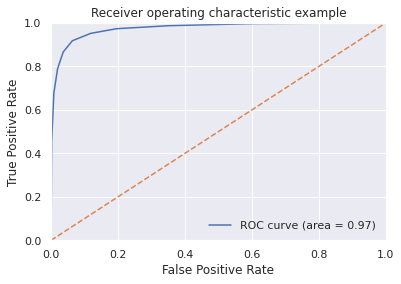

In [ ]:
y_pred = Grid_forest.predict(X_test_DT)
y_pred_DT = cross_val_predict(Grid_forest, X_test_DT, y_test_DT, method='predict_proba', cv = 5)
#this part should be for test data, but I just wanted to see it
get_auc(np.array(y_test_DT), y_pred_DT, class_labels, column=0, plot=True)

In [ ]:
print ("Accuracy (cross-validated): ", round(accuracy_score(y_test_DT, y_pred),3))
print (classification_report(y_test_DT, y_pred))

Accuracy (cross-validated):  0.948
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3745
           1       0.94      0.96      0.95      3647

    accuracy                           0.95      7392
   macro avg       0.95      0.95      0.95      7392
weighted avg       0.95      0.95      0.95      7392



### All Data $\to$ Train $\to$ Test $\to$ export result

In [ ]:
Grid_forest.fit(X, y)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,...
                         'max_leaf_nodes': [None], 'max_samples': [None],
                         'min_impurity_decrease': [0.0],
                         'min_impurity_split': [None], 'min_

In [ ]:
y_test_prob = Grid_forest.predict_proba(X_test)

In [ ]:
result = pd.DataFrame(ID_test)
result['HOSPITAL_EXPIRE_FLAG'] = y_test_prob[:,1].round(2)
result.to_csv('../../Data/project/Forest_test_result_new2.csv', index=False)

## Gradient Boosting

### Split $\to$ Gridsearch $\to$ Train $\to$ Test

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
#to test the effect of removing less important variables

np.random.seed(3123) # impose random seed for reproducibility
feature_names = new_col_names

treeXGB = GradientBoostingClassifier(n_estimators=9)
scores = cross_val_score(treeXGB, X_train_DT, y_train_DT, cv=10,  scoring='roc_auc')
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

importance = treeXGB.fit(X_train_DT, y_train_DT).feature_importances_
important_features = pd.Series(data=importance/importance.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.948 (+/- 0.011)


ICD9_diagnosis           1.000000
ICD9_diagnosis_other2    0.707648
ICD9_diagnosis_other     0.388829
DIAGNOSIS                0.183933
SysBP_Min                0.002184
Diabetes_situation       0.000000
SpO2_Min                 0.000000
RespRate_Mean            0.000000
TempC_Min                0.000000
TempC_Max                0.000000
TempC_Mean               0.000000
SpO2_Max                 0.000000
RespRate_Min             0.000000
SpO2_Mean                0.000000
Glucose_Min              0.000000
Glucose_Max              0.000000
RespRate_Max             0.000000
MeanBP_Min               0.000000
MeanBP_Mean              0.000000
MeanBP_Max               0.000000
SEQ_NUM                  0.000000
DiasBP_Mean              0.000000
DiasBP_Max               0.000000
DiasBP_Min               0.000000
SysBP_Mean               0.000000
SysBP_Max                0.000000
HeartRate_Mean           0.000000
HeartRate_Max            0.000000
Glucose_Mean             0.000000
num_prev_stay 

In [ ]:
#Notice: params were tuned with different values, however for the sake of speed 
#we changed them to optimum values here.
params = {'criterion':['friedman_mse'],
          'loss':['deviance'], 'max_depth':[9], 'max_features':[None],
          'max_leaf_nodes':[None], 
          'min_impurity_decrease':[0.0], 'min_impurity_split':[None],
          'min_samples_leaf':[1], 'min_samples_split':[2],
          'min_weight_fraction_leaf':[0.0], 'n_estimators':[9],
          'random_state':[None],
          'verbose':[0], 'warm_start':[False]
          }
Grid_GBX = GridSearchCV(treeXGB, param_grid = params ,scoring = 'precision',
                                cv=StratifiedKFold(n_splits=10, shuffle=True),
                                refit=True,n_jobs=10)
Grid_GBX.estimator


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=9,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
Grid_GBX.fit(X_train_DT, y_train_DT)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2...
                         'max_depth': [9], 'max_features': [None],
                         'max_leaf_nodes': [None],
                         'min_impurit

AUC:  0.9660421371626844


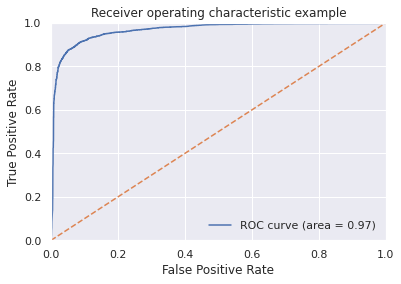

In [ ]:
y_pred = Grid_GBX.predict(X_test_DT)
y_pred_DT = cross_val_predict(Grid_GBX, X_test_DT, y_test_DT, method='predict_proba', cv = 5)
#this part should be for test data, but I just wanted to see it
get_auc(np.array(y_test_DT), y_pred_DT, class_labels, column=0, plot=True)

In [ ]:
print ("Accuracy (cross-validated): ", round(accuracy_score(y_test_DT, y_pred),3))
print (classification_report(y_test_DT, y_pred))

Accuracy (cross-validated):  0.932
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3745
           1       0.91      0.96      0.93      3647

    accuracy                           0.93      7392
   macro avg       0.93      0.93      0.93      7392
weighted avg       0.93      0.93      0.93      7392



In [ ]:
y_hat_XGB = Grid_GBX.predict_proba(X_test)[:,1]
y_hat_XGB

array([0.20797484, 0.7152961 , 0.20303557, ..., 0.20168   , 0.20100432,
       0.2030523 ])

### All Data $\to$ Train $\to$ Test $\to$ export result

In [ ]:
Grid_GBX.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2...
                         'max_depth': [9], 'max_features': [None],
                         'max_leaf_nodes': [None],
                         'min_impurit

In [ ]:
y_pred_prob_test = Grid_GBX.predict_proba(X_test)

In [ ]:
result = pd.DataFrame(ID_test)
result['HOSPITAL_EXPIRE_FLAG'] = y_pred_prob_test[:,1].round(2)
result.to_csv('../../Data/project/GBX02.csv', index=False)

In [ ]:
result.HOSPITAL_EXPIRE_FLAG.value_counts()

0.20    5533
0.21    1504
0.22     379
0.25     267
0.23     230
        ... 
0.51      35
0.77      19
0.80       5
0.18       3
0.81       2
Name: HOSPITAL_EXPIRE_FLAG, Length: 62, dtype: int64

#**Conclusion**

1. Which model is the best?

All the models have good accuracies, but the important charactristic in Decision tree, Gradient Boosting and Random Forest is that they are really dependent on max_Depth. if we increase max depth and involve more features and splits, we can easily overfit (as it is shown in each model section as an example). On the other hand, hyperparameter tuining in Decision tree, Gradient Boosting and Random Forest has much higher cost compared to Logestic Regression. Therefore, we have decided to use Logestic Regression and the sample result submitted in the kaggle competition section is a result given by the Logestic Regresssion.